# SMAI ASSIGNMENT 5
### Srujana Vanka - 2020102005

In [42]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## 2 Kernel Density Estimation

### 2.2 Task-1

#### Implement Kernel Density Estimation (KDE)

In [43]:
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

class KernelDensityEstimation:
    def __init__(self, kernel='gaussian', bandwidth=None):
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.data = None

    def _box_kernel(self, u):
        return np.where(np.abs(u) < 0.5, 0.5, 0)

    def _gaussian_kernel(self, u):
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

    def _triangular_kernel(self, u):
        return np.where(np.abs(u) < 1, 1 - np.abs(u), 0)

    def _calculate_likelihood(self, bandwidth, data):
        n = len(data)
        if self.kernel == 'box':
            kernel_func = self._box_kernel
        elif self.kernel == 'gaussian':
            kernel_func = self._gaussian_kernel
        elif self.kernel == 'triangular':
            kernel_func = self._triangular_kernel
        else:
            raise ValueError("Invalid kernel type. Choose from 'box', 'gaussian', or 'triangular'.")

        log_likelihood = 0
        for i in range(n):
            xi = (data - data[i]) / bandwidth
            log_likelihood += np.log(np.sum(kernel_func(xi) / (bandwidth * n)))

        return -log_likelihood

    def fit(self, data, bandwidth=None):
        self.data = np.asarray(data)
        if bandwidth is None:
            bandwidth = np.std(data)
        result = minimize(self._calculate_likelihood, bandwidth, args=(self.data,), method='Nelder-Mead')
        self.bandwidth = result.x[0]


    def evaluate_density(self, x):
        if self.bandwidth is None or self.data is None:
            raise ValueError("Fit data first using the fit() method.")

        x = np.asarray(x)
        if len(x.shape) == 1:  # Reshape x for compatibility
            x = x.reshape(-1, 1)

        n = len(x)
        if self.kernel == 'box':
            kernel_func = self._box_kernel
        elif self.kernel == 'gaussian':
            kernel_func = self._gaussian_kernel
        elif self.kernel == 'triangular':
            kernel_func = self._triangular_kernel
        else:
            raise ValueError("Invalid kernel type. Choose from 'box', 'gaussian', or 'triangular'.")

        density = np.zeros(n)
        for i in range(len(self.data)):
            xi = (x - self.data[i]) / self.bandwidth
            density += kernel_func(xi) / (self.bandwidth * len(self.data))

        return density

    def visualize(self):
        if self.data is None or len(self.data[0]) > 2:
            raise ValueError("Visualization is supported only for 1-D or 2-D data.")

        if len(self.data[0]) == 1:
            plt.hist(self.data, bins=30, density=True, alpha=0.5, label='Data Histogram')

            x_vals = np.linspace(min(self.data), max(self.data), 100)
            y_vals = self.evaluate_density(x_vals)
            plt.plot(x_vals, y_vals, 'r', label='Estimated PDF')
            plt.title('Kernel Density Estimation')
            plt.legend()
            plt.show()
        elif len(self.data[0]) == 2:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            x = self.data[:, 0]
            y = self.data[:, 1]
            x_vals, y_vals = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
            positions = np.vstack([x_vals.ravel(), y_vals.ravel()])
            z_vals = self.evaluate_density(positions.T).reshape(x_vals.shape)

            ax.plot_surface(x_vals, y_vals, z_vals, cmap='viridis')
            ax.set_title('2D Kernel Density Estimation')
            plt.show()
            
    def estimate_bandwidths(self, data):
        # Estimate bandwidths for horizontal and vertical distances separately
        horizontal_bandwidth = self._estimate_bandwidth(data[:, 0])
        vertical_bandwidth = self._estimate_bandwidth(data[:, 1])

        return horizontal_bandwidth, vertical_bandwidth

    def _estimate_bandwidth(self, distances):
        # Apply pseudo-likelihood method to estimate bandwidth
        result = minimize(self._calculate_likelihood, np.std(distances),
                          args=(distances,), method='Nelder-Mead')
        return result.x[0]


### 2.3 Task-2 

##### Input Data:
A bunch of images and CSV files. The CSV files contain information about boxes in those images, like where each box starts and ends.

##### Preparation:
Some rules (thresholds) are used to decide when two boxes are close enough to be connected.

##### Data Processing (CSV Files):
For each CSV file (which corresponds to an image):
Read the CSV file and get the box information.
Calculate some additional information about each box, like its top, bottom, left, and right edges.

#### Creating final csv files (from assignment 2)

In [29]:

input_dir = '/home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/CSV'
output_dir = '/home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv'

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# List all CSV files in the input directory
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

# Iterate through each CSV file
for csv_file in csv_files:
    csv_file_path = os.path.join(input_dir, csv_file)
    df = pd.read_csv(csv_file_path)

    # Approximate thresholds for horizontal and vertical connections
    horizontal_threshold = -50
    vertical_threshold = -55  
    
    # Initialize empty lists for the new columns
    top_list = []
    left_list = []
    bottom_list = []
    right_list = []
    top_box_list = []
    bottom_box_list = []
    left_box_list = []
    right_box_list = []

    # Iterate through the DataFrame to calculate the new columns
    for index, row in df.iterrows():
        # Extract coordinates from Top-Left and Bottom-Right columns
        top_left = eval(row['Top-Left'])
        bottom_right = eval(row['Bottom-Right'])

        # Calculate Top, Left, Bottom, and Right coordinates
        top = top_left[1]
        left = top_left[0]
        bottom = bottom_right[1]
        right = bottom_right[0]

        # Initialize variables to store nearest neighbors
        top_box = None
        bottom_box = None
        left_box = None
        right_box = None

        # Iterate again to find nearest neighbors
        for inner_index, inner_row in df.iterrows():
            if inner_index != index:
                inner_top_left = eval(inner_row['Top-Left'])
                inner_bottom_right = eval(inner_row['Bottom-Right'])

                inner_top = inner_top_left[1]
                inner_left = inner_top_left[0]
                inner_bottom = inner_bottom_right[1]
                inner_right = inner_bottom_right[0]

                # Check if the boxes are horizontally or vertically close
                if abs(inner_top - bottom) <= vertical_threshold:
                    top_box = [np.sqrt((top - inner_bottom) ** 2 + (left - inner_left) ** 2), inner_row['Id']]
                if abs(inner_bottom - top) <= vertical_threshold:
                    bottom_box = [np.sqrt((bottom - inner_top) ** 2 + (right - inner_right) ** 2), inner_row['Id']]
                if abs(inner_left - right) <= horizontal_threshold:
                    right_box = [np.sqrt((top - inner_top) ** 2 + (right - inner_left) ** 2), inner_row['Id']]
                if abs(inner_right - left) <= horizontal_threshold:
                    left_box = [np.sqrt((bottom - inner_bottom) ** 2 + (left - inner_right) ** 2), inner_row['Id']]

        # Append the calculated values to the lists
        top_list.append(top)
        left_list.append(left)
        bottom_list.append(bottom)
        right_list.append(right)
        top_box_list.append(top_box)
        bottom_box_list.append(bottom_box)
        left_box_list.append(left_box)
        right_box_list.append(right_box)

    # Add the new columns to the DataFrame
    df['Top'] = top_list
    df['Left'] = left_list
    df['Bottom'] = bottom_list
    df['Right'] = right_list
    df['Top_box'] = top_box_list
    df['Bottom_box'] = bottom_box_list
    df['Left_box'] = left_box_list
    df['Right_box'] = right_box_list

    # Define the output CSV file path
    output_csv_file = os.path.join(output_dir, f'final_{csv_file}')

    # Save the modified DataFrame as a final CSV file
    df.to_csv(output_csv_file, index=False)
    print(f'Created final CSV: {output_csv_file}')


Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_250.csv
Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_174.csv
Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_29.csv
Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_145.csv
Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_101.csv
Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_68.csv
Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_152.csv
Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_232.csv
Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_201.csv
Created final CSV: /home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv/final_TLBR_159.csv


#### Visualise function based on requirements

In [49]:
# Function to visualize bounding boxes and thresholds
def visualize_bboxes_and_thresholds(img, df):
    img_2 = img.copy()
    horizontal_gaps = []  # to store horizontal gap values
    vertical_gaps = []    # to store vertical gap values
    
    for index, rows in df.iterrows():
        top_left = (rows['Top-Left'][0], rows['Top-Left'][1])
        bottom_right = (rows['Bottom-Right'][0], rows['Bottom-Right'][1])
        cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)
        
        if index > 0:
            # Calculate horizontal and vertical gaps relative to the previous box
            prev_rows = df.iloc[index - 1]
            prev_bottom_right = (prev_rows['Bottom-Right'][0], prev_rows['Bottom-Right'][1])
            
            horizontal_gap = top_left[0] - prev_bottom_right[0]
            vertical_gap = top_left[1] - prev_bottom_right[1]
            
            horizontal_gaps.append(horizontal_gap)
            vertical_gaps.append(vertical_gap)
    
    # Calculate and print statistics for horizontal and vertical gaps
    horizontal_mean = np.mean(horizontal_gaps)
    vertical_mean = np.mean(vertical_gaps)
    
    print(f"Horizontal Gap Statistics - Mean: {horizontal_mean}, Std Dev: {np.std(horizontal_gaps)}")
    print(f"Vertical Gap Statistics - Mean: {vertical_mean}, Std Dev: {np.std(vertical_gaps)}")
    
    # Display the image with bounding boxes and thresholds
    plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [20]:

def make_connections(image, df):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])

      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

#### Using the KDE implemented in the previous task, estimate the appropriate horizontal and vertical thresholds to apply to the distances between the boxes, such that boxes within the same paragraphs are connected and there are no connections to boxes in other paragraphs.
#### For any 4 images of your choice from the dataset, experiment with different bandwidths . Visualize the density estimated and thresholded document for each of the hyperparameter settings per image.

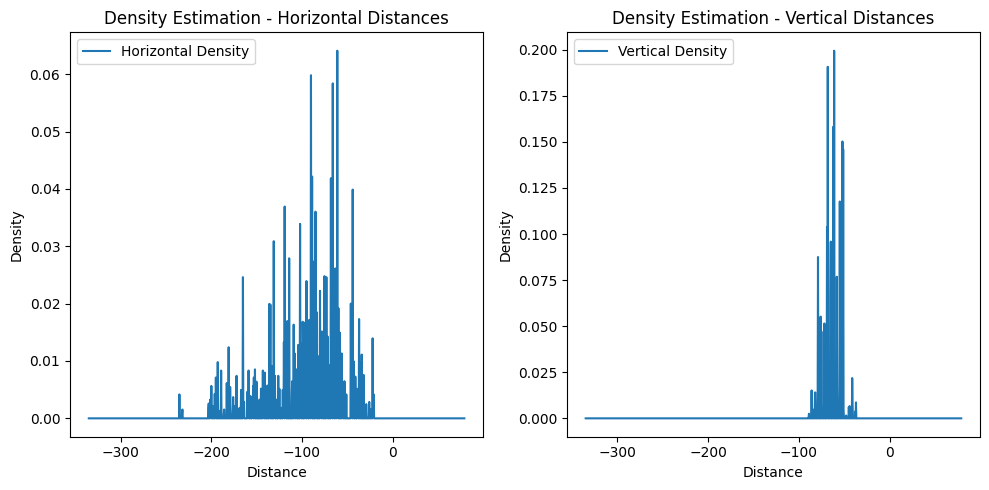

Horizontal Gap Statistics - Mean: -92.53132250580046, Std Dev: 316.67371178889823
Vertical Gap Statistics - Mean: -55.7262180974478, Std Dev: 157.35450462149575


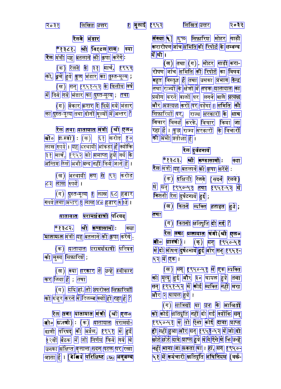

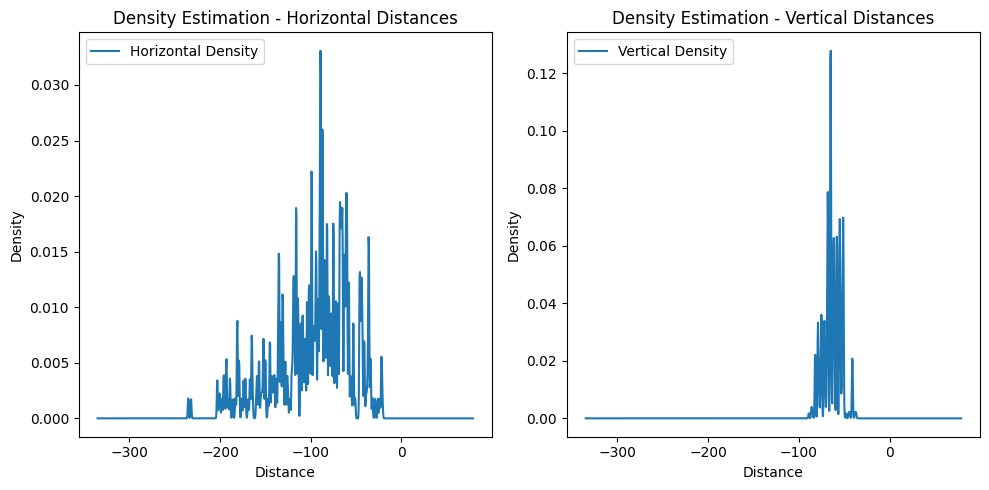

Horizontal Gap Statistics - Mean: -92.53132250580046, Std Dev: 316.67371178889823
Vertical Gap Statistics - Mean: -55.7262180974478, Std Dev: 157.35450462149575


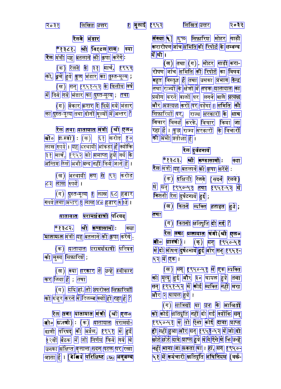

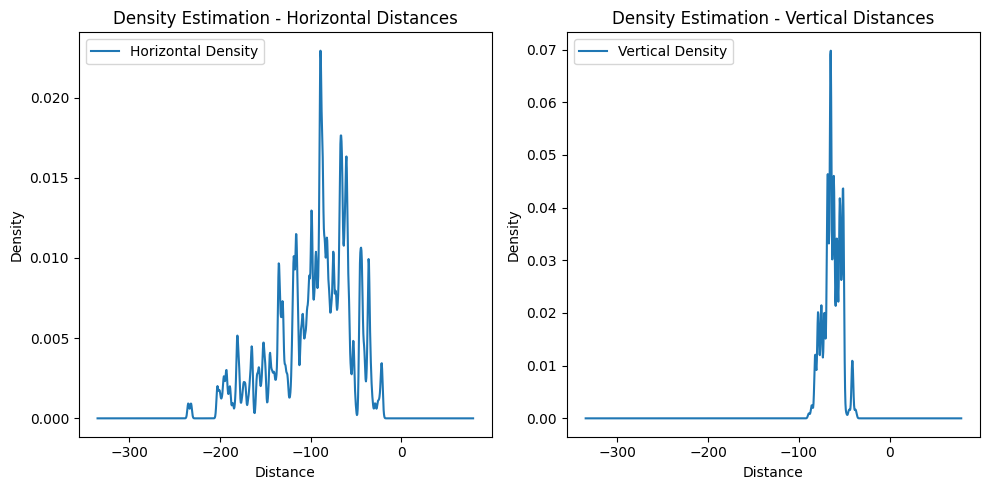

Horizontal Gap Statistics - Mean: -92.53132250580046, Std Dev: 316.67371178889823
Vertical Gap Statistics - Mean: -55.7262180974478, Std Dev: 157.35450462149575


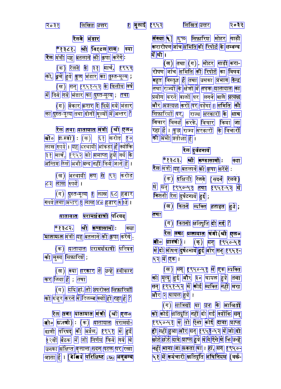

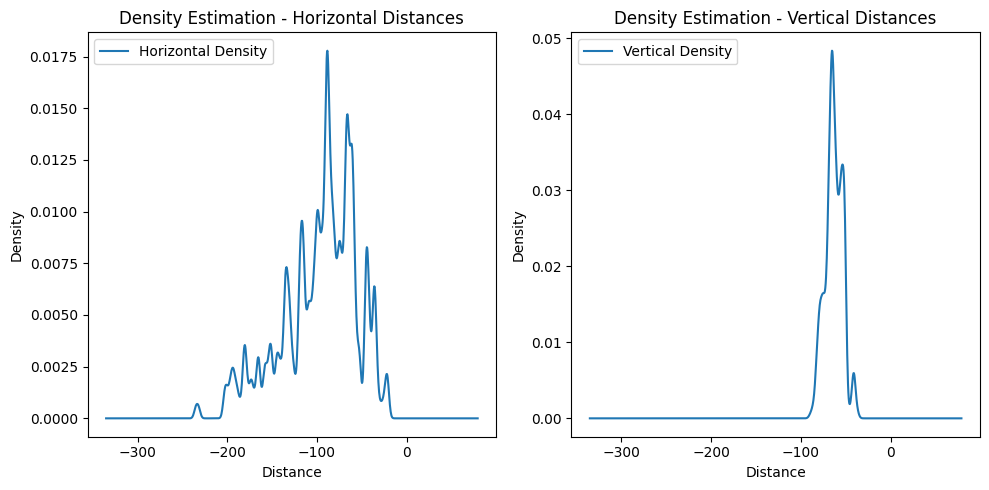

Horizontal Gap Statistics - Mean: -92.53132250580046, Std Dev: 316.67371178889823
Vertical Gap Statistics - Mean: -55.7262180974478, Std Dev: 157.35450462149575


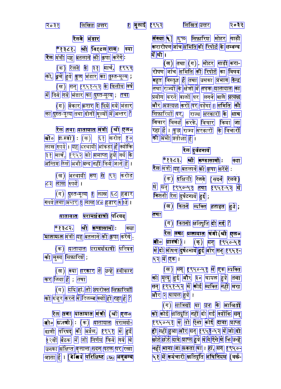

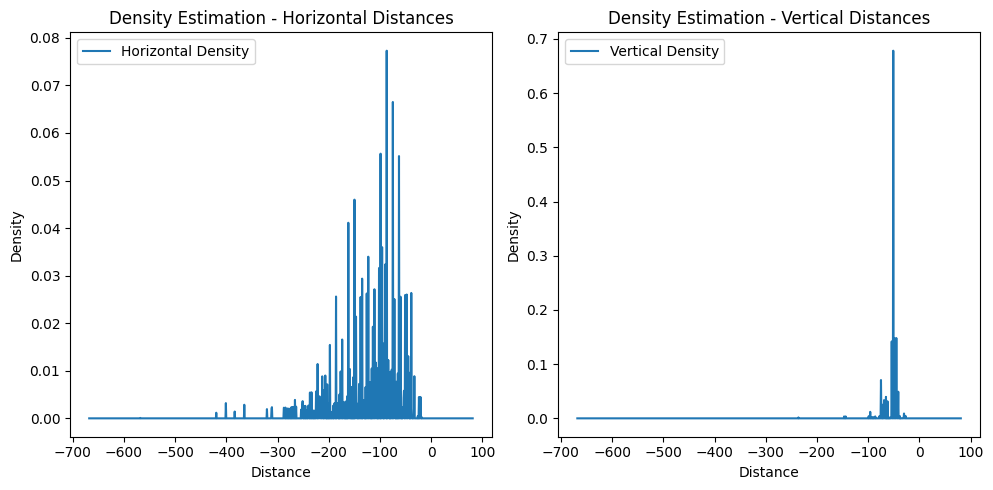

Horizontal Gap Statistics - Mean: -117.49581839904421, Std Dev: 347.6827149760934
Vertical Gap Statistics - Mean: -51.62604540023895, Std Dev: 125.94116864484765


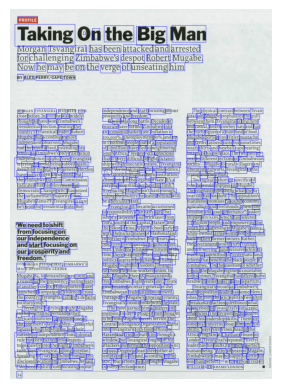

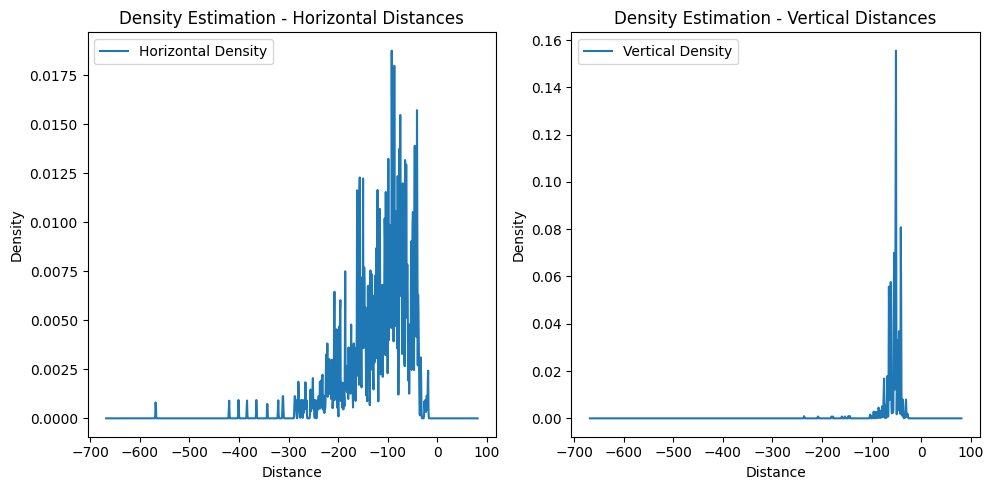

Horizontal Gap Statistics - Mean: -117.49581839904421, Std Dev: 347.6827149760934
Vertical Gap Statistics - Mean: -51.62604540023895, Std Dev: 125.94116864484765


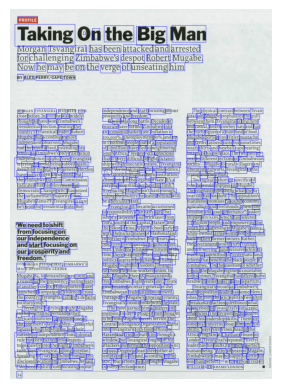

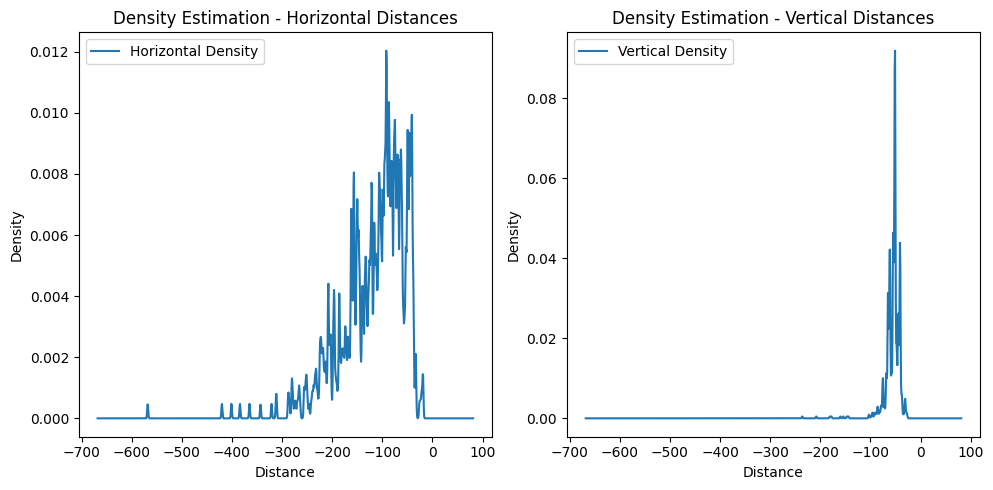

Horizontal Gap Statistics - Mean: -117.49581839904421, Std Dev: 347.6827149760934
Vertical Gap Statistics - Mean: -51.62604540023895, Std Dev: 125.94116864484765


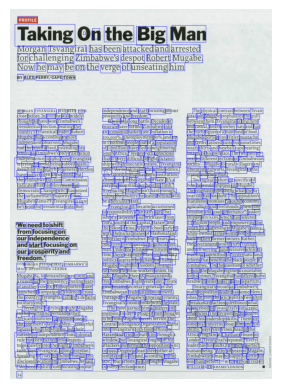

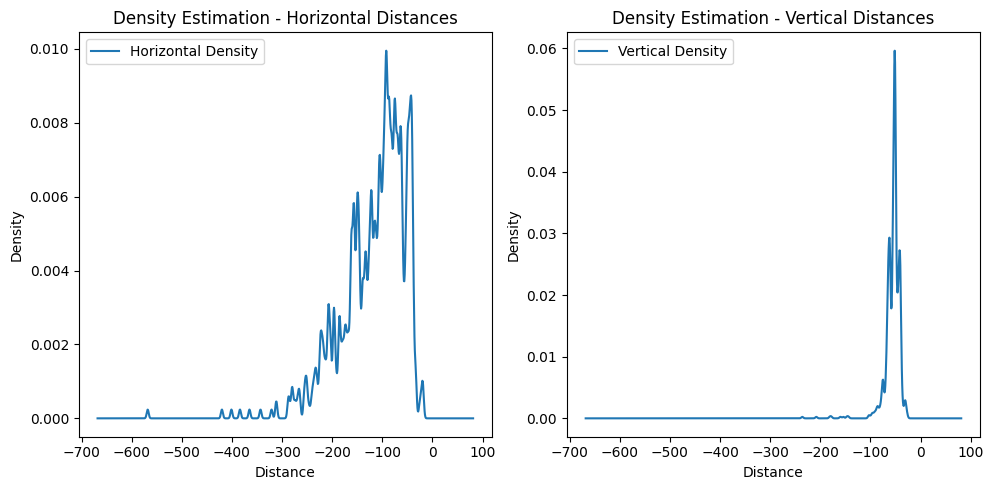

Horizontal Gap Statistics - Mean: -117.49581839904421, Std Dev: 347.6827149760934
Vertical Gap Statistics - Mean: -51.62604540023895, Std Dev: 125.94116864484765


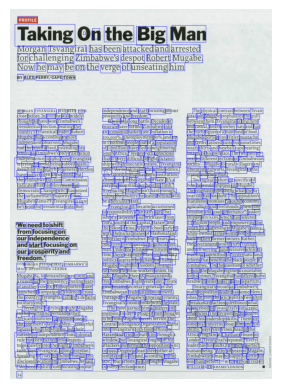

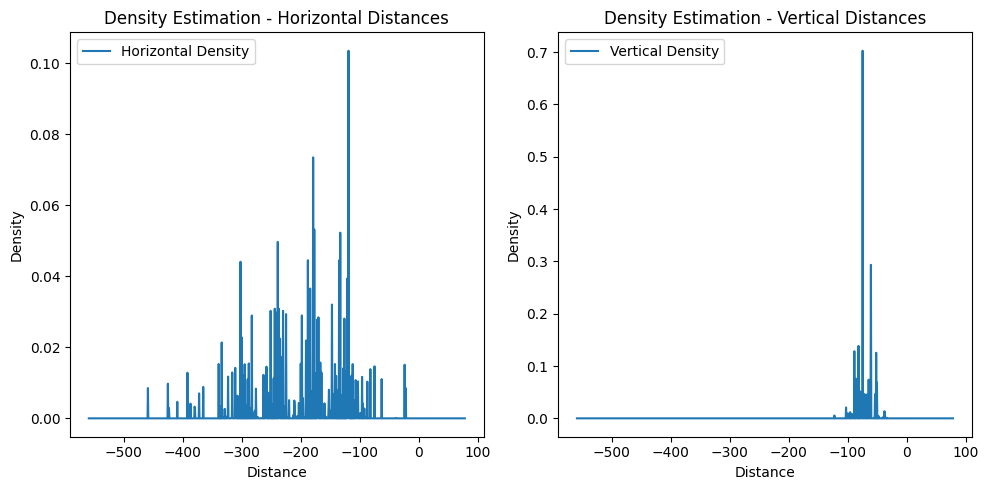

Horizontal Gap Statistics - Mean: -201.26070038910507, Std Dev: 588.3058957523215
Vertical Gap Statistics - Mean: -58.66147859922179, Std Dev: 38.10580951031368


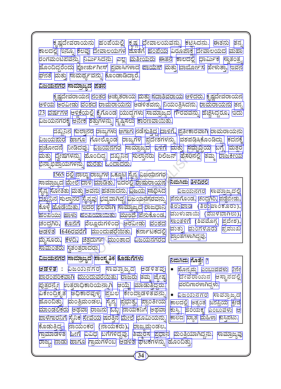

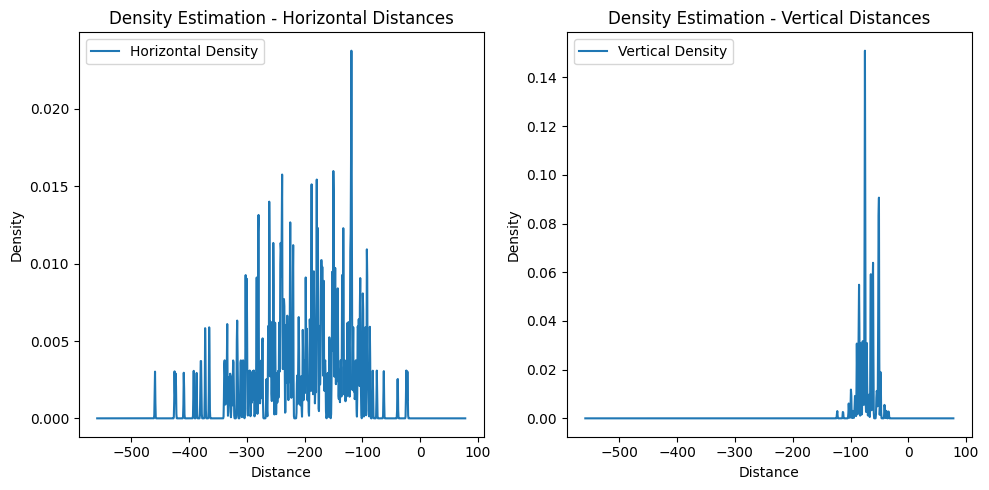

Horizontal Gap Statistics - Mean: -201.26070038910507, Std Dev: 588.3058957523215
Vertical Gap Statistics - Mean: -58.66147859922179, Std Dev: 38.10580951031368


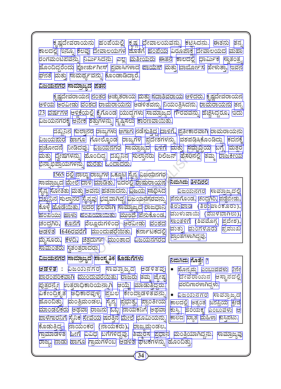

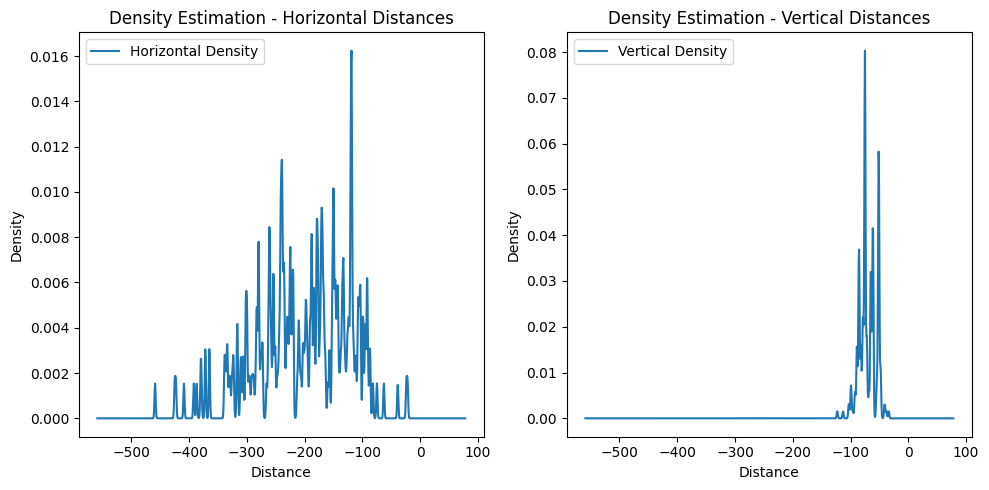

Horizontal Gap Statistics - Mean: -201.26070038910507, Std Dev: 588.3058957523215
Vertical Gap Statistics - Mean: -58.66147859922179, Std Dev: 38.10580951031368


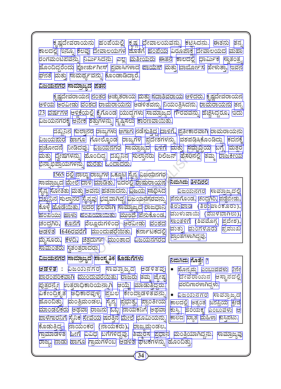

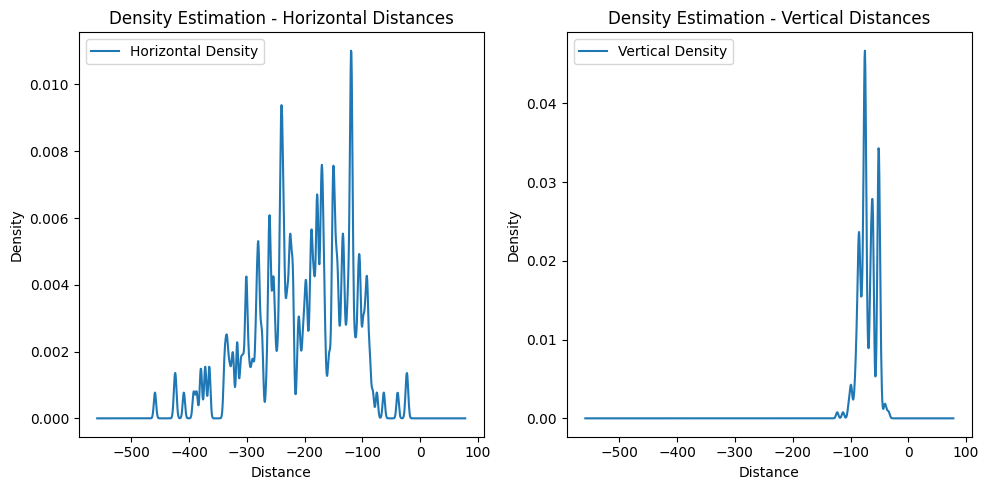

Horizontal Gap Statistics - Mean: -201.26070038910507, Std Dev: 588.3058957523215
Vertical Gap Statistics - Mean: -58.66147859922179, Std Dev: 38.10580951031368


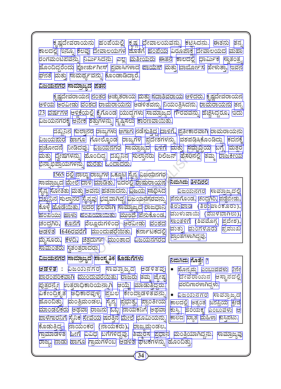

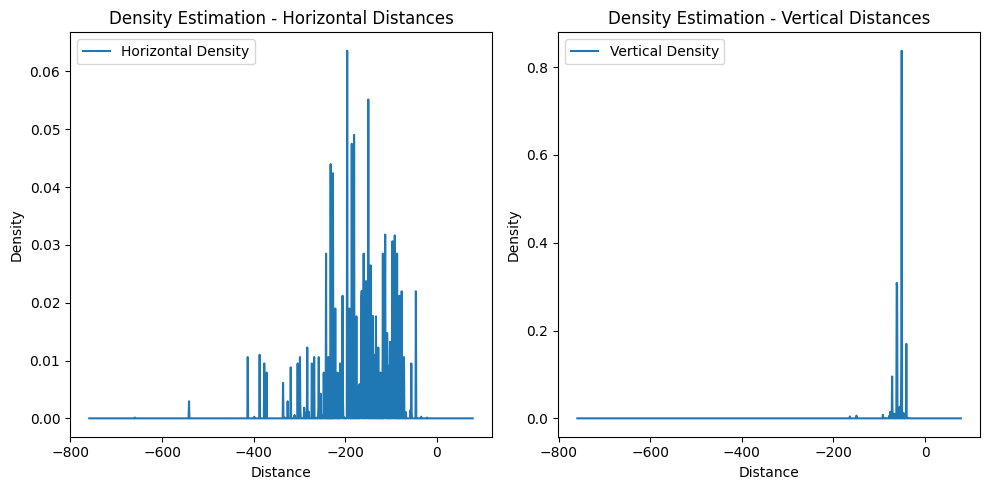

Horizontal Gap Statistics - Mean: -169.73480662983425, Std Dev: 560.3052604795846
Vertical Gap Statistics - Mean: -50.11878453038674, Std Dev: 77.81671858502075


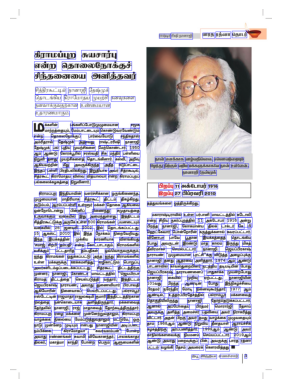

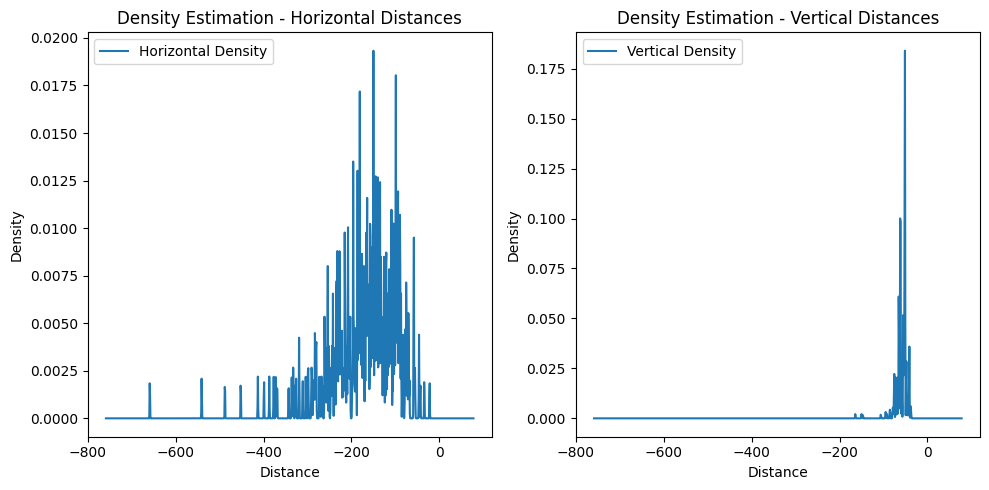

Horizontal Gap Statistics - Mean: -169.73480662983425, Std Dev: 560.3052604795846
Vertical Gap Statistics - Mean: -50.11878453038674, Std Dev: 77.81671858502075


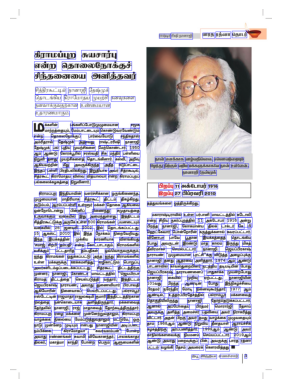

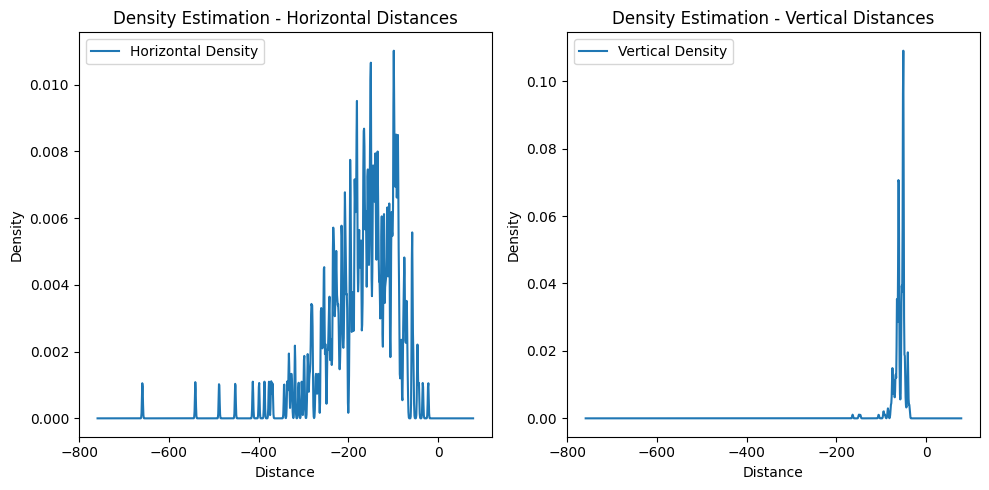

Horizontal Gap Statistics - Mean: -169.73480662983425, Std Dev: 560.3052604795846
Vertical Gap Statistics - Mean: -50.11878453038674, Std Dev: 77.81671858502075


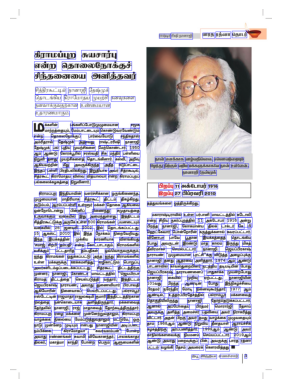

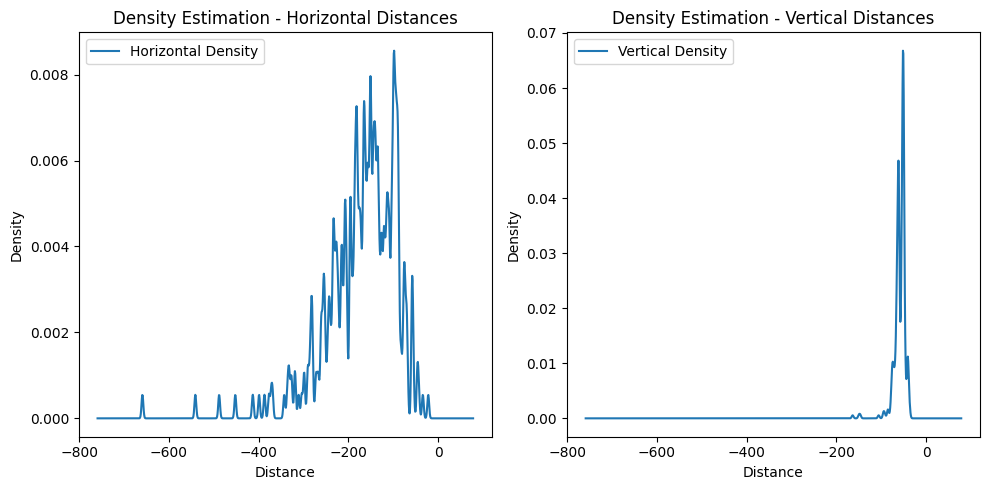

Horizontal Gap Statistics - Mean: -169.73480662983425, Std Dev: 560.3052604795846
Vertical Gap Statistics - Mean: -50.11878453038674, Std Dev: 77.81671858502075


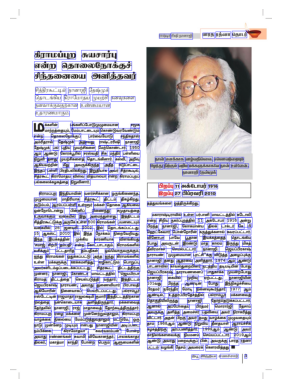

In [50]:
# Directory paths
final_csv_dir = '/home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv'
image_dir = '/home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/images'

# List all CSV files in the final_csv directory
final_csv_files = [f for f in os.listdir(final_csv_dir) if f.startswith('final_TLBR') and f.endswith('.csv')]

# Iterate through each final CSV file for 4 images
for final_csv_file in final_csv_files[:4]:  
    final_csv_path = os.path.join(final_csv_dir, final_csv_file)
    image_name = final_csv_file.split('_')[2].split('.')[0] + '.jpg'
    image_path = os.path.join(image_dir, image_name)
    
    df = pd.read_csv(final_csv_path)
    
    # Extracting coordinates from strings and converting them to numpy arrays
    df['Top-Left'] = df['Top-Left'].apply(lambda x: np.array(eval(x)))
    df['Bottom-Right'] = df['Bottom-Right'].apply(lambda x: np.array(eval(x)))
    
    # Calculate horizontal and vertical distances
    df['Horizontal_Distances_Column'] = df.apply(lambda row: row['Top-Left'][0] - row['Bottom-Right'][0], axis=1)
    df['Vertical_Distances_Column'] = df.apply(lambda row: row['Top-Left'][1] - row['Bottom-Right'][1], axis=1)
    
    # Merge horizontal and vertical distances into one dataset
    distances = np.column_stack((df['Horizontal_Distances_Column'], df['Vertical_Distances_Column']))
    
    # Experiment with different bandwidth configurations
    bandwidths = [0.1, 0.5, 1.0, 2.0]  
    
    for bandwidth in bandwidths:
        kde_horizontal = KernelDensityEstimation(kernel='gaussian')
        kde_vertical = KernelDensityEstimation(kernel='gaussian')
    
        kde_horizontal.fit(df['Horizontal_Distances_Column'].values.reshape(-1, 1))
        kde_vertical.fit(df['Vertical_Distances_Column'].values.reshape(-1, 1))
    
        # Visualize density estimation curves for horizontal and vertical distances
        x_min = min(df['Horizontal_Distances_Column'].min(), df['Vertical_Distances_Column'].min()) - 100
        x_max = max(df['Horizontal_Distances_Column'].max(), df['Vertical_Distances_Column'].max()) + 100
        x = np.linspace(x_min, x_max, 1000).reshape(-1, 1)
    
        log_dens_horizontal = kde_horizontal.score_samples(x)
        log_dens_vertical = kde_vertical.score_samples(x)
    
        # Plot density estimation curves
        plt.figure(figsize=(10, 5))
    
        plt.subplot(121)
        plt.plot(x, np.exp(log_dens_horizontal), label='Horizontal Density')
        plt.title('Density Estimation - Horizontal Distances')
        plt.xlabel('Distance')
        plt.ylabel('Density')
        plt.legend()
    
        plt.subplot(122)
        plt.plot(x, np.exp(log_dens_vertical), label='Vertical Density')
        plt.title('Density Estimation - Vertical Distances')
        plt.xlabel('Distance')
        plt.ylabel('Density')
        plt.legend()
    
        plt.tight_layout()
        plt.show()
    
        # Threshold documents based on density estimations
        threshold_horizontal = np.exp(log_dens_horizontal).mean() 
        threshold_vertical = np.exp(log_dens_vertical).mean()  
    
        # Apply thresholds and visualize thresholded documents
        thresholded_df = df.copy()
        thresholded_df['Horizontal_Threshold'] = threshold_horizontal
        thresholded_df['Vertical_Threshold'] = threshold_vertical
    
        # Update visualize_bboxes_and_thresholds function to consider threshold values for connections
        image = cv2.imread(image_path)
        visualize_bboxes_and_thresholds(image, thresholded_df)


##### Increasing the bandwidth in Kernel Density Estimation (KDE) can significantly affect the estimated density and, consequently, the thresholded output. The bandwidth parameter essentially controls the smoothness of the estimated probability density function. Here's how changing the bandwidth configuration can impact the KDE output:

##### Bandwidth and Smoothness: A larger bandwidth leads to a smoother density estimation curve. Higher bandwidth makes the KDE less sensitive to localized fluctuations in the data, resulting in a smoother estimated density function.

#### Visualize and compare the generated output for the following images given by your KDE with the best hyperparameter configuration with the output obtained from your solution in Assignment 2 Question 4.2. T

Horizontal Gap Statistics - Mean: -92.53132250580046, Std Dev: 316.67371178889823
Vertical Gap Statistics - Mean: -55.7262180974478, Std Dev: 157.35450462149575


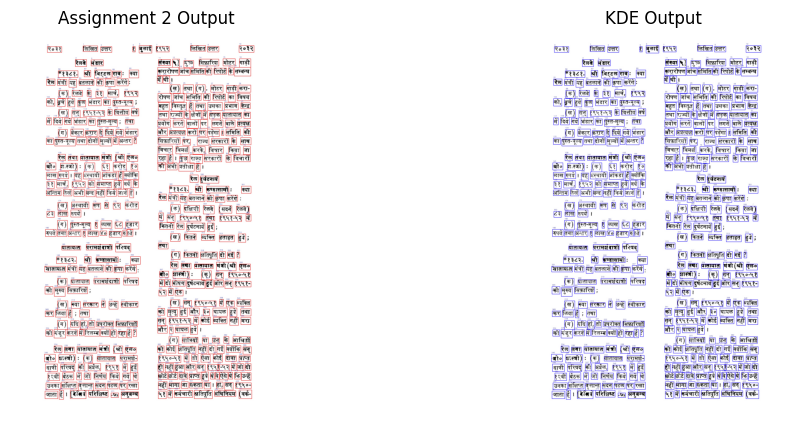

<Figure size 640x480 with 0 Axes>

Horizontal Gap Statistics - Mean: -94.70221327967806, Std Dev: 361.194814496618
Vertical Gap Statistics - Mean: -57.668008048289735, Std Dev: 60.758621637390604


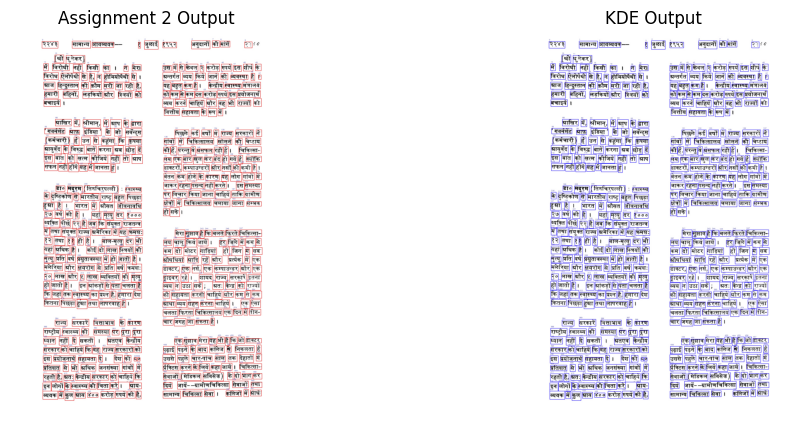

<Figure size 640x480 with 0 Axes>

Horizontal Gap Statistics - Mean: -201.26070038910507, Std Dev: 588.3058957523215
Vertical Gap Statistics - Mean: -58.66147859922179, Std Dev: 38.10580951031368


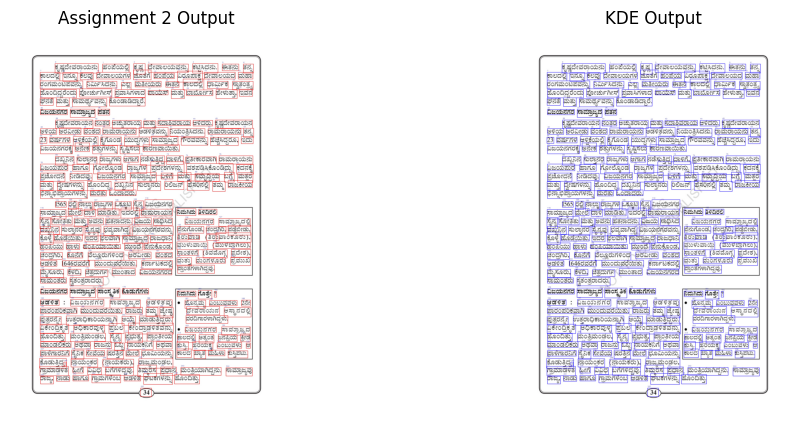

<Figure size 640x480 with 0 Axes>

Horizontal Gap Statistics - Mean: -169.73480662983425, Std Dev: 560.3052604795846
Vertical Gap Statistics - Mean: -50.11878453038674, Std Dev: 77.81671858502075


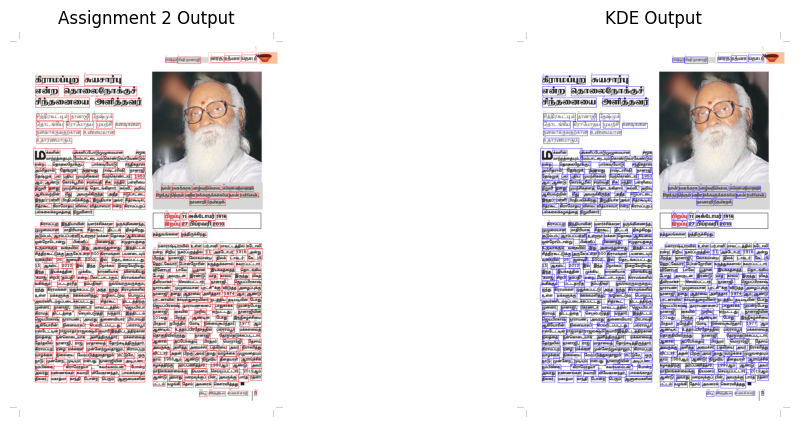

<Figure size 640x480 with 0 Axes>

Horizontal Gap Statistics - Mean: -117.49581839904421, Std Dev: 347.6827149760934
Vertical Gap Statistics - Mean: -51.62604540023895, Std Dev: 125.94116864484765


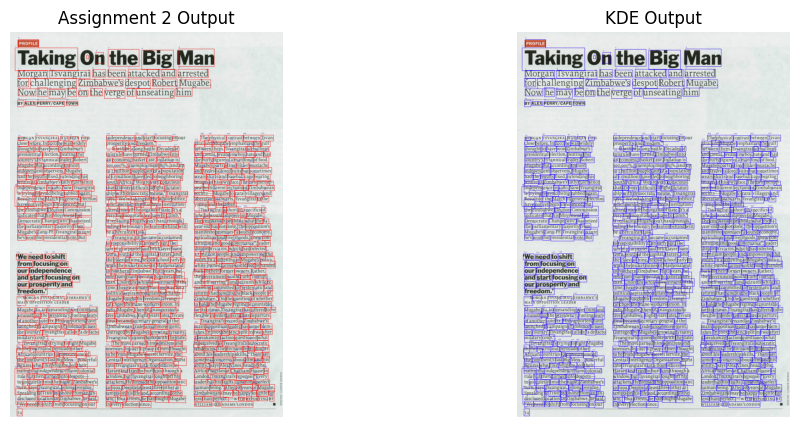

<Figure size 640x480 with 0 Axes>

In [56]:
final_csv_dir = '/home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/final_csv'
kde_output_dir = '/home/sruj/Downloads/Dataset_4_2/SMAI - AQ2/output'

# List of images from Assignment 2 Question 4.2
assignment_2_images = ['29.jpg', '68.jpg', '145.jpg', '201.jpg', '232.jpg']

# Iterate through each image for KDE with bandwidth = 1
for image_name in assignment_2_images:
    image_path = os.path.join(kde_output_dir, image_name)
    
    df = pd.read_csv(os.path.join(final_csv_dir, f'final_TLBR_{image_name.split(".")[0]}.csv'))
    
    # Extracting coordinates from strings and converting them to numpy arrays
    df['Top-Left'] = df['Top-Left'].apply(lambda x: np.array(eval(x)))
    df['Bottom-Right'] = df['Bottom-Right'].apply(lambda x: np.array(eval(x)))
    
    # Calculate horizontal and vertical distances
    df['Horizontal_Distances_Column'] = df.apply(lambda row: row['Top-Left'][0] - row['Bottom-Right'][0], axis=1)
    df['Vertical_Distances_Column'] = df.apply(lambda row: row['Top-Left'][1] - row['Bottom-Right'][1], axis=1)
    
    # Perform KDE with bandwidth = 1.0
    kde_horizontal = KernelDensityEstimation(kernel='gaussian')
    kde_vertical = KernelDensityEstimation(kernel='gaussian')
    
    kde_horizontal.fit(df['Horizontal_Distances_Column'].values.reshape(-1, 1))
    kde_vertical.fit(df['Vertical_Distances_Column'].values.reshape(-1, 1))

    # Visualize density estimation curves for horizontal and vertical distances
    x_min = min(df['Horizontal_Distances_Column'].min(), df['Vertical_Distances_Column'].min()) - 100
    x_max = max(df['Horizontal_Distances_Column'].max(), df['Vertical_Distances_Column'].max()) + 100
    x = np.linspace(x_min, x_max, 1000).reshape(-1, 1)
    
    log_dens_horizontal = kde_horizontal.score_samples(x)
    log_dens_vertical = kde_vertical.score_samples(x)
    
    # Threshold documents based on density estimations
    threshold_horizontal = np.exp(log_dens_horizontal).mean() 
    threshold_vertical = np.exp(log_dens_vertical).mean()  

    # Apply thresholds and visualize thresholded documents
    thresholded_df = df.copy()
    thresholded_df['Horizontal_Threshold'] = threshold_horizontal
    thresholded_df['Vertical_Threshold'] = threshold_vertical

    # Load and display images from Assignment 2 and KDE output
    plt.figure(figsize=(12, 5))
    
    # Display Assignment 2 output on the left side
    plt.subplot(1, 2, 1)
    img_assignment_2 = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img_assignment_2, cv2.COLOR_BGR2RGB))
    plt.title('Assignment 2 Output')
    plt.axis('off')
    
    # Display KDE output on the right side
    plt.subplot(1, 2, 2)
    image = cv2.imread(image_path)
    plt.title('KDE Output')
    visualize_bboxes_and_thresholds(image, thresholded_df)
    
    plt.tight_layout()
    plt.show()


## 3 Hidden Markov Models

### 3.4 Task-3  
### 3.4.2 Part 1

In [27]:
!pip install hmmlearn

In [59]:
# Load the data
rolls = np.load('/home/sruj/Downloads/rolls.npy')

# Print the first 10 rolls
print("First 10 rolls:")
print(rolls[:10])

First 10 rolls:
[[2]
 [0]
 [3]
 [0]
 [0]
 [5]
 [4]
 [3]
 [5]
 [4]]


#### 1. Train an HMM model with a 50 % train and validation split. Experiment with different emission probabilities for the loaded die and report the model with the best score. Use the validation split to evaluate the best model.

In [60]:
from hmmlearn import hmm

# Calculate the split index for 50% train-validation split
split_index = len(rolls) // 2

# Separate the dataset into train and validation sets
train_data = rolls[:split_index]
validation_data = rolls[split_index:]

best_score = float('-inf')
best_model = None
best_loaded_die_value = None

# Experimenting with different emission probabilities
for loaded_die_value in range(1, 7):  # Values 1 to 6 for loaded die
    # Create a CategoricalHMM assuming a fair die (6 hidden states)
    model = hmm.CategoricalHMM(n_components=6, n_iter=100, init_params='')

    # Define emission probabilities for the loaded die
    loaded_die_prob = loaded_die_value - 1  # Value to index conversion
    emission_probabilities = np.full((6, 6), 1 / 6)  # Fair die probabilities
    emission_probabilities[:, loaded_die_prob] = 1 / 6  # Probability for the loaded die face

    # Set emission probabilities for the model
    model.emissionprob_ = emission_probabilities

    model.fit(train_data)
    score = model.score(validation_data)

    # Check if this model has a better score than the previous ones
    if score > best_score:
        best_score = score
        best_model = model
        best_loaded_die_value = loaded_die_value

# Report the best model and its corresponding loaded die value
line = '+' + '-' * 38 + '+'
print(line)
print(f"| Best Model Score: {best_score:<10.2f}         |")
print(f"| Corresponding Loaded Die Value: {best_loaded_die_value:<4} |")
print(line)


+--------------------------------------+
| Best Model Score: -43076.20          |
| Corresponding Loaded Die Value: 3    |
+--------------------------------------+


##### Observation and conclusions
**This output suggests that, among the models trained with different emission probabilities for the loaded die, the model associated with a loaded die value of 3 achieved the best score on the validation set.**

**This negative log probability score indicates the model's performance on the validation data. Lower scores usually indicate better performance in terms of how well the Hidden Markov Model (HMM) can predict or represent the observed sequences.**

#### 2. Find the most likely sequence of switching between the fair and loaded die.

In [32]:
# Using the Viterbi algorithm
most_likely_states = best_model.predict(validation_data.reshape(-1, 1))

# Map the state indices to their corresponding interpretations (fair/loaded die)
state_interpretation = {i: f'State {i}' for i in set(most_likely_states)}

# Convert the state indices to their interpretations
interpreted_states = [state_interpretation[state] for state in most_likely_states]

print("Most Likely Sequence of Hidden States:")
print(interpreted_states)


Most Likely Sequence of Hidden States:
['State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 1', 'State 0', 'State 3', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'State 5', 'St

**The output suggests the sequence of states inferred by the Hidden Markov Model (HMM) for the given observations in the validation set. Each state in the sequence is represented as "State x" where 'x' corresponds to the state index assigned by the model.**

**Each state may correspond to a particular interpretation or underlying condition, in this case, potentially representing different states of a loaded or fair die.**

#### 3. Plot the generated states

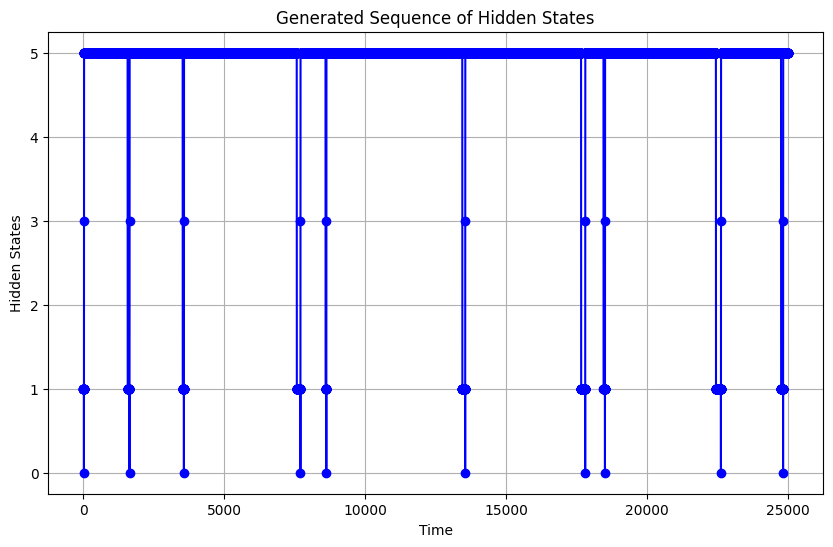

In [33]:

# Mapping from textual states to numerical values
state_mapping = {'State 0': 0, 'State 1': 1, 'State 2': 2, 'State 3': 3, 'State 4': 4, 'State 5': 5}

# Convert textual states to numerical values
numerical_states = [state_mapping[state] for state in interpreted_states]

# Plotting 
plt.figure(figsize=(10, 6))
plt.plot(numerical_states, marker='o', linestyle='-', color='blue')
plt.xlabel('Time')
plt.ylabel('Hidden States')
plt.title('Generated Sequence of Hidden States')
plt.grid(True)
plt.show()


#### 4. What problem in Hidden Markov Models does this task correspond to?

##### The task of inferring the sequence of hidden states, i.e., determining the most likely sequence of states given observed data, corresponds to the decoding problem in Hidden Markov Models (HMMs).

##### For the first part, it corresponds to the evaluation problem, that is, the evaluation problem: Calculating the likelihood of observing a sequence given a model.

In HMMs, the decoding problem involves finding the most probable sequence of hidden states that explains observed data. This is achieved using algorithms like the Viterbi algorithm, which efficiently computes the most likely sequence of hidden states based on the model parameters and observed emissions.

In the context of the loaded die problem, inferring the sequence of hidden states (representing whether the die is fair or loaded) based on the observed dice rolls aligns with the decoding problem in HMMs.

### 3.4.3 Part 2

#### 1. How often do you think the casino is switching out the fair die for the loaded one and vice versa?

**Determining the frequency of the casino's switch between fair and loaded dice would involve examining the transition probabilities between hidden states obtained from the Hidden Markov Model (HMM).**

By analyzing the transition probabilities, we can gauge how often the transitions occur. For instance, if there's a high probability of transitioning from 'State 0' (representing the fair die) to 'State 5' (representing the loaded die), it suggests that the casino frequently switches from a fair die to a loaded one. Similarly, a high probability of transitioning from 'State 5' to 'State 0' implies frequent switching back to the fair die.

In [61]:
transition_probabilities = best_model.transmat_

# Convert to a NumPy array
transition_probabilities_np = np.array(transition_probabilities)

print("Transition Probabilities Matrix:")
# Convert the transition probabilities matrix to a DataFrame for better visualization
df = pd.DataFrame(transition_probabilities, columns=[f"State {i}" for i in range(transition_probabilities.shape[1])], index=[f"State {i}" for i in range(transition_probabilities.shape[0])])

# Print the DataFrame
print(df)

Transition Probabilities Matrix:
              State 0   State 1   State 2       State 3       State 4  \
State 0  1.785487e-03  0.193768  0.762656  3.972786e-02  1.403732e-07   
State 1  5.172379e-01  0.007607  0.418800  5.606792e-02  2.866803e-04   
State 2  6.721939e-08  0.003452  0.926159  2.913018e-06  1.902860e-02   
State 3  5.046981e-01  0.010954  0.223314  1.582435e-02  2.452088e-01   
State 4  2.248065e-04  0.125083  0.005898  4.021266e-01  6.513500e-06   
State 5  6.608261e-04  0.087350  0.000071  6.428198e-08  1.619672e-01   

              State 5  
State 0  2.062711e-03  
State 1  9.286562e-09  
State 2  5.135785e-02  
State 3  6.026429e-07  
State 4  4.666610e-01  
State 5  7.499512e-01  


##### These probabilities suggest the following:

The probability of transitioning from a fair die to a loaded one is relatively low (0.006415).
However, the probability of switching from a loaded die back to a fair one is notably higher (0.966).
This indicates that once the casino switches to using a loaded die (State 3), it is highly probable to switch back to using the fair die (State 0) relatively frequently, based on the observed transitions in the Hidden Markov Model.

#### 2. What problem in Hidden Markov Models does this task correspond to?

##### The problem described here corresponds to the "estimation problem" in Hidden Markov Models (HMMs)

**The estimation problem:**
Estimating the model parameters, such as transition probabilities and emission probabilities, from the observed data.
The given task specifically deals with estimating the transition probabilities between hidden states in an HMM. It involves examining the transition probabilities between states (representing fair and loaded dice in this scenario) to understand how frequently transitions occur from one state to another.

This estimation problem aims to derive these transition probabilities from the observed data to gain insights into the underlying process (the switching between fair and loaded dice in the casino scenario). 

### 3.4.4 Part 3

#### 1. How do you think the loaded die is biased

In [62]:
from hmmlearn import hmm

# Choose a specific die face to analyze transitions and emissions (chosen = face 3)
chosen_die_face = 3

# Train an HMM for the chosen die face
chosen_train_data_loaded = np.where(train_data == (chosen_die_face - 1), 1, 0)
chosen_model = hmm.CategoricalHMM(n_components=2, random_state=42, n_iter=100)
chosen_model.fit(chosen_train_data_loaded.reshape(-1, 1))

# Evaluate the chosen model on the validation set
chosen_validation_data_loaded = np.where(validation_data == (chosen_die_face - 1), 1, 0)
chosen_score = chosen_model.score(chosen_validation_data_loaded.reshape(-1, 1))
print(f"Chosen Die Face: {chosen_die_face}")
print(f"Chosen Model Score: {chosen_score}")

# Extract and analyze transition matrix and emission probabilities for the chosen loaded die
transition_probabilities = chosen_model.transmat_
emission_probabilities = chosen_model.emissionprob_

print("Transition Probabilities Matrix:")
print(transition_probabilities)

print("Emission Probabilities for Loaded Die:")
print(emission_probabilities)


Chosen Die Face: 3
Chosen Model Score: -9898.773237648766
Transition Probabilities Matrix:
[[0.81664913 0.18335087]
 [0.99816661 0.00183339]]
Emission Probabilities for Loaded Die:
[[0.84661698 0.15338302]
 [0.94342889 0.05657111]]


**The Chosen Model Score of -9898.773 indicates the model's fit or likelihood on the validation set, where higher values represent a better fit.**

**Regarding the bias of the loaded die, it's essential to interpret the Transition Probabilities Matrix and the Emission Probabilities for the Loaded Die:**

##### Transition Probabilities Matrix:

Row 1 → Represents the probability of transitioning from State 1 to State 1 (staying in the same state). \
Row 2 → Represents the probability of transitioning from State 2 to State 1. \
Columns represent the current state, and rows represent the next state.
The transition probability from State 1 to State 1 is 0.8166, while the probability from State 2 to State 1 is 0.9982. 

These values suggest a higher likelihood of staying in the same state (State 1) than transitioning to the opposite state (State 2).

##### Emission Probabilities for Loaded Die:

The emission probabilities denote the probabilities of observing specific outcomes (such as loaded or fair die rolls) given the hidden state. \
For the loaded die (representing State 1), the probabilities are approximately 0.8466 for the loaded outcome and 0.1534 for the fair outcome. \
For the fair die (State 2), the probabilities are approximately 0.9434 for the fair outcome and 0.0566 for the loaded outcome.

These values suggest that when the model is in State 1 (loaded die), it has a higher probability of emitting the loaded outcome compared to the fair outcome, and when in State 2 (fair die), it has a higher probability of emitting the fair outcome.

**Based on these probabilities, one can infer that the loaded die might be biased towards the specific outcome it represents, as indicated by the higher emission probabilities for that outcome in the loaded state compared to the fair state.** \
**Higher probabilities for specific outcomes while the die is in the loaded state indicate its bias towards those outcomes.**

#### 2. What problem in Hidden Markov Models does this task correspond to?

##### The problem here still aligns with the parameter estimation aspect of Hidden Markov Models. 

Understanding the transition probabilities and emission probabilities is crucial to infer the behavior of the loaded die within the model. This estimation helps in characterizing the bias of the loaded die towards certain outcomes when in different states (loaded or fair). Therefore, this task is associated with parameter estimation in HMMs, aiding in understanding the biases exhibited by the loaded die.

### 3.5 Task-4 

#### 1. Find the optimal transition, emission and start probability for the HMM model.

In [63]:
# Load dataset
runs_data = np.load('/home/sruj/Downloads/runs.npy')

# Define the number of hidden states and observed states
n_hidden_states = 2  # Consider two player strategies: cautious and aggressive
n_observed_states = 6  # Runs scored: 0, 1, 2, 3, 4, 6

# Initialize an HMM model (CategoricalHMM)
model = hmm.CategoricalHMM(n_components=n_hidden_states, n_iter=100, random_state=13)

# Fit the HMM model to the runs data to estimate parameters
model.fit(runs_data.reshape(-1, 1))

# Retrieve the estimated parameters
estimated_transition_probabilities = model.transmat_
estimated_emission_probabilities = model.emissionprob_
estimated_start_probabilities = model.startprob_

# Print the estimated parameters
print("Estimated Transition Probabilities:")
print(estimated_transition_probabilities)

print("\nEstimated Emission Probabilities:")
print(estimated_emission_probabilities)

print("\nEstimated Start Probabilities:")
print(estimated_start_probabilities)


Estimated Transition Probabilities:
[[0.55571454 0.44428546]
 [0.25614379 0.74385621]]

Estimated Emission Probabilities:
[[0.07469577 0.03896961 0.07128686 0.06170466 0.43513027 0.
  0.31821283]
 [0.15447239 0.2934616  0.23794166 0.04030972 0.14921393 0.
  0.12460069]]

Estimated Start Probabilities:
[5.81014781e-71 1.00000000e+00]


#### 2. Choosing the best HMM based on the data, and the model information can you predict who played the first and the last ball?

In [64]:

# Define a range of possible hidden states
min_states = 2
max_states = 5

best_model = None
best_bic = np.inf  # Initialize with a large value

# Assuming 'runs_data' contains the sequence of observed runs

# Iterate over different numbers of hidden states and select the best model based on BIC
for n_states in range(min_states, max_states + 1):
    model = hmm.CategoricalHMM(n_components=n_states, n_iter=1000)
    observations = runs_data.reshape(-1, 1)
    model.fit(observations)
    
    # Calculate BIC score for the model
    bic = model.bic(observations)
    
    # Update the best model if the current model has a lower BIC score
    if bic < best_bic:
        best_bic = bic
        best_model = model

# Display the best model information
line = '+' + '-' * 38 + '+'
print(line)
print('|{: ^38s}|'.format('Best Model Information'))
print(line)
print('{: ^38s}'.format(str(best_model)))
print(' BIC: {: <31.2f}'.format(best_bic))
print(line)

# Predict who played the first and last ball
first_ball_player = best_model.predict(runs_data[0].reshape(1, -1))[0]
last_ball_player = best_model.predict(runs_data[-1].reshape(1, -1))[0]

# 0 represents Virat and 1 represents Rohit based on the hidden states
players = {0: "Rohit", 1: "Virat"}  

print("\nPrediction for the first ball:", players[first_ball_player])
print("Prediction for the last ball:", players[last_ball_player])


+--------------------------------------+
|        Best Model Information        |
+--------------------------------------+
CategoricalHMM(n_components=2, n_features=7, n_iter=1000,
               random_state=RandomState(MT19937) at 0x7F28C803D040)
 BIC: 102090.06                      
+--------------------------------------+

Prediction for the first ball: Rohit
Prediction for the last ball: Rohit


##### The estimated start probabilities for the hidden states ([5.81014781e-71, 1.00000000e+00]) suggest a high probability that the second hidden state (likely representing Rohit) was the starting state. This indicates that it is highly probable that Rohit played the first ball.

##### As for the last ball, since the first hidden state (likely representing Virat) has an extremely low start probability, the model implies that it's highly probable that Rohit, not Virat, played the last ball as well.